In [0]:
from __future__ import print_function, division
import os
import torch
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io
import torch.nn as nn
import torch.nn.functional as F

from skimage.color import rgb2gray

from torch.utils.tensorboard import SummaryWriter

import PIL
from PIL import Image

from google.colab import output

In [4]:
%cd /content/
if(os.path.isdir('/content/Lithuanian_OCR') == False):
  !git clone https://github.com/PauliusMilmantas/Lithuanian_OCR

num_of_classes = 3

/content


In [0]:
class ORCDataset(Dataset):
  def __init__(self, root):
    self.root = root

  def __len__(self):
    lt = 0
    classes = os.listdir(self.root)
    for cl in classes:
      lt += len(os.listdir(self.root + '/' + cl))

    return lt

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
     idx = idx.tolist()

    if(idx <= len(self)):
      found_file = ""
      found_type = ""

      fldrs = os.listdir(self.root)
      for fld in fldrs:
        fls = os.listdir(self.root + '/' + fld + '/')
        for fl in fls:
          if(fl == str(idx) + ".jpg"):
            found_file = self.root + '/' + fld + '/' + fl         
            found_type = fld

      try:
        img = io.imread(found_file)
        img = rgb2gray(img)

        return {'image': img, 'class_name': found_type}
      except:
        if(found_file != ""):
          print("Bad file: " + found_file)
        else:
          print("File not found, idx = " + str(idx))
    else:
      print()
      raise Exception("Dataset index out of boundaries")

train_dataset = ORCDataset('/content/Lithuanian_OCR/Data/batch-1/training')
val_dataset = ORCDataset('/content/Lithuanian_OCR/Data/batch-1/val')
test_dataset = ORCDataset('/content/Lithuanian_OCR/Data/batch-1/test')

In [0]:
class Net(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)        
        out = self.relu2(out)     
        out = self.fc3(out)
        return out

In [39]:
network = Net(4096, 1500, 300, num_of_classes)
network.cuda()
optimizer = torch.optim.SGD(network.parameters(), lr=0.01, momentum=0.6)
criterion = nn.MSELoss().cuda()

print(network)

Net(
  (fc1): Linear(in_features=4096, out_features=1500, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=1500, out_features=300, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=300, out_features=3, bias=True)
)


In [0]:
network.load_state_dict(torch.load('/content/Lithuanian_OCR/Trained_model/model.pth'))
network.eval()

optimizer = torch.optim.SGD(network.parameters(), lr=0.2, momentum=0.2)
optimizer.load_state_dict(torch.load('/content/Lithuanian_OCR/Trained_model/optimizer.pth'))

In [7]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
network.to(dev)
criterion.to(dev)
dev

device(type='cuda')

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cuda

Tesla K80
Memory Usage:
Allocated: 0.1 GB
Cached:    0.1 GB


In [0]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = len(train_dataset),shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = len(val_dataset), shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = len(test_dataset), shuffle=True)

Class name: B


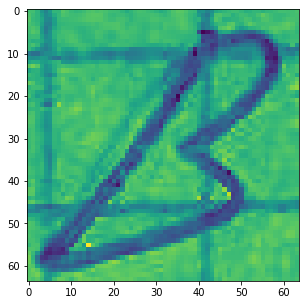

In [11]:
dataiter = iter(train_loader)
itr = dataiter.next()

label = itr['class_name']
img = itr['image']
print("Class name: {}".format(label[0]))

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img[0])

In [0]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(10 + 1)]

In [0]:
!mkdir results

In [0]:
def name_to_int(data):

  switcher = {
      'A': 1,
      'B': 2,
      'C': 3,
      'A_small': 4,
      'P': 5,
      'u': 6
  }

  new_data = []

  for dt in data:
    new_data.append(switcher.get(dt))

  return new_data

In [0]:
def get_max_from_tensor(data):
  maxVal = data[0]
  maxId = 0
  for i in range(len(data)):
    if(data[i] > maxVal):
      maxVal = data[i]
      maxId = i

  return maxId + 1

In [49]:
def train(train_loader, val_loader, epoch_amount, save_checkpoint = 10):
  network.eval()
  train_loss_hist = []
  val_loss_hist = []
  checkpoint = save_checkpoint
  for epoch in range(epoch_amount):
    num_images_train = 0
    num_images_val = 0

    # TRAINING DATASET
    correct = 0
    for data in train_loader:
      images = data['image']
      labels = torch.from_numpy(np.array(name_to_int(data['class_name'])))

      num_images_train = len(images)

      lossSum = 0
      for idx in range(len(images)):
        optimizer.zero_grad()

        outputs = network(images[idx].cuda().flatten().float())

        maxIdx = get_max_from_tensor(outputs)
        real_value = np.zeros(num_of_classes)
        real_value[labels[idx] - 1] = 1

        loss = criterion(outputs.cuda(), torch.Tensor(real_value).cuda()) 
        
        loss.backward()

        lossSum += loss.item()
        train_loss_hist.append(lossSum)

        optimizer.step()

    # VALIDATION
    for data in val_loader:
      images = data['image']
      labels = torch.from_numpy(np.array(name_to_int(data['class_name'])))

      images.cuda()
      labels.cuda()

      num_images_val = len(images)

      lossSum = 0
      for idx in range(len(images)):
        optimizer.zero_grad()

        outputs = network(images[idx].cuda().flatten().float())

        if(labels[idx] == get_max_from_tensor(outputs)):
          correct += 1

        maxIdx = get_max_from_tensor(outputs)
        real_value = np.zeros(num_of_classes)
        real_value[labels[idx] - 1] = 1
        loss = criterion(outputs.cuda(), torch.Tensor(real_value).cuda()) 

        lossSum += loss.item()
        val_loss_hist.append(lossSum)

    print("Epoch: {} Training loss: {} Eval loss: {} Correct: {}%".format(epoch,train_loss_hist[len(train_loss_hist) - 1],val_loss_hist[len(val_loss_hist) - 1],correct*100/num_images_train))

    if(checkpoint == 0):
      torch.save(network.state_dict(), '/content/results/model.pth')
      torch.save(optimizer.state_dict(), '/content/results/optimizer.pth')

      checkpoint = save_checkpoint
    else:
      checkpoint -= 1

train(train_loader, val_loader, 200, 5)

Epoch: 0 Training loss: 4.9235183919877495e-06 Eval loss: 1.1487466120552199 Correct: 29.05982905982906%
Epoch: 1 Training loss: 4.923553629689395e-06 Eval loss: 1.148746596676574 Correct: 29.05982905982906%
Epoch: 2 Training loss: 4.923510642814918e-06 Eval loss: 1.1487465668487857 Correct: 29.05982905982906%
Epoch: 3 Training loss: 4.923446299617482e-06 Eval loss: 1.148746611617753 Correct: 29.05982905982906%
Epoch: 4 Training loss: 4.923406701331026e-06 Eval loss: 1.1487465837471973 Correct: 29.05982905982906%
Epoch: 5 Training loss: 4.92335463131606e-06 Eval loss: 1.1487465890295425 Correct: 29.05982905982906%
Epoch: 6 Training loss: 4.9233806035586455e-06 Eval loss: 1.1487465393502134 Correct: 29.05982905982906%
Epoch: 7 Training loss: 4.923344280114393e-06 Eval loss: 1.1487465307136517 Correct: 29.05982905982906%
Epoch: 8 Training loss: 4.923288818867687e-06 Eval loss: 1.1487465333948421 Correct: 29.05982905982906%
Epoch: 9 Training loss: 4.923241801422194e-06 Eval loss: 1.148746

In [50]:
for data in test_loader:
  images = data['image']
  labels = torch.from_numpy(np.array(name_to_int(data['class_name'])))

  for i in range(len(images)):
    output = network(images[i].cuda().flatten().float())
    
    if(get_max_from_tensor(output) == labels[i]):
      print("OK: {} == {}".format(get_max_from_tensor(output), labels[i]))
    else:
      print("False: {} == {}".format(get_max_from_tensor(output), labels[i]))

OK: 1 == 1
OK: 2 == 2
OK: 1 == 1
OK: 2 == 2
OK: 1 == 1
OK: 2 == 2
OK: 1 == 1
OK: 1 == 1
False: 2 == 1
OK: 1 == 1
OK: 3 == 3
OK: 3 == 3
OK: 2 == 2
OK: 3 == 3
OK: 3 == 3
OK: 2 == 2


In [0]:
for opt in optimizer.param_groups:
  opt['lr'] = 0.000001

In [0]:
!cp '/content/results/model.pth' '/content/Lithuanian_OCR/Trained_model/model.pth'
!cp '/content/results/optimizer.pth' '/content/Lithuanian_OCR/Trained_model/optimizer.pth'